In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
# Add Day, Hour and Slice columns to the redteam data, set Attack to True and add user suffix to match event logs

secDay = 86400
secHour = 3600
secSlice = 600

redDf = pd.read_csv('D:\\LANL\\2015\\Raw\\redteam.txt.gz', compression='gzip', \
                    names=['Time', 'Attacker', 'Attacking', 'Attacked'])

redDf['Day'] = redDf['Time'].apply(lambda x : int((x/secDay)+1))
redDf['Hour'] = redDf['Time'].apply(lambda x : int((x/secHour)%24))
redDf['Slice'] = redDf['Time'].apply(lambda x : int(x/secSlice))
redDf = redDf.astype({'Time': 'int', 'Day': 'int', 'Hour': 'int', 'Slice': 'int'})
redDf['Attack']=True
pd.set_option('display.max_rows', 1000)


redDf[redDf['Day']<17].Slice.nunique()

204

In [ ]:
# Build the NLP Model ML training and testing

# Set the fraction of data sampling and create the enpty model dataframe
sampleRate = 1
modelDf=pd.DataFrame(columns=['Activity', 'Attack'])

# Cycle through selected days and read feature data
for day in range(2,16):
    procDf = pd.read_pickle('D:\\LANL\\2015\\Analysis\\Day_' +  str(day).zfill(2) + '_procFeat.pkl', \
                            compression='gzip')
    authDf = pd.read_pickle('D:\\LANL\\2015\\Analysis\\Day_' +  str(day).zfill(2) + '_authFeat.pkl', \
                            compression='gzip')

    # Filter User data only and Merge process and authentication features into a single dataframe
    procDf = procDf[procDf['User'].str.contains('^U[0-9]{1}')]
    authDf = authDf[authDf['User'].str.contains('^U[0-9]{1}')]
    
    mergeDf = authDf.merge(procDf, how='outer', left_on=['Day', 'Hour', 'Slice', 'User'], \
                               right_on=['Day', 'Hour', 'Slice', 'User'])

    # Add the attack truth data which adds a new 'Attack' column, set to True or False and remove null values
    mergeDf = mergeDf.merge(redDf[redDf['Day']==day], how='outer', left_on=['Day', 'Hour', 'Slice', 'User'], \
                               right_on=['Day', 'Hour', 'Slice', 'Attacker'])
    mergeDf['Attack'].fillna(False, inplace=True)
    mergeDf=mergeDf.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna(''))
    
    # Sample the data according to the smaple rate
    mergeDf = mergeDf[mergeDf['Attack']].append(mergeDf.sample(frac=sampleRate))

    # Create a new host 'Activity' column as a space delimeted string for NLP modelling
    cols=['Processes', 'Computers', 'DestComputers', 'AuthTypes', 'AuthOrients', 'LogonTypes']
    mergeDf['Activity'] = mergeDf[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    mergeDf['Activity'] =  mergeDf['Activity'].str.replace('\W', ' ').str.replace('  ', ' ')
    
    # Randomize and append selected data to the model dataframe
    modelDf = modelDf.append(mergeDf[['Activity', 'Attack']].sample(frac=1, random_state=42))
    
len(modelDf)
    

In [8]:
# Build the NLP Model ML training and testing

# Set the fraction of data sampling and create the enpty model dataframe
sampleRate = 0.001
modelDf=pd.DataFrame(columns=['Activity', 'Attack'])

# Cycle through selected days and read feature data
for day in range(2,16):
    procDf = pd.read_pickle('D:\\LANL\\2015\\Analysis\\Day_' +  str(day).zfill(2) + '_procFeat.pkl', \
                            compression='gzip')
    authDf = pd.read_pickle('D:\\LANL\\2015\\Analysis\\Day_' +  str(day).zfill(2) + '_authFeat.pkl', \
                            compression='gzip')

    # Filter User data only and Merge process and authentication features into a single dataframe
    procUserDf = procDf[procDf['User'].str.contains('^U[0-9]{1}')]
    authUserDf = authDf[authDf['User'].str.contains('^U[0-9]{1}')]
    procCompDf = procDf[procDf['User'].str.contains('^C[0-9]{1}')]
    authCompDf = authDf[authDf['User'].str.contains('^C[0-9]{1}')]
    
    mergeDf = authUserDf.merge(procUserDf, how='outer', left_on=['Day', 'Hour', 'Slice', 'User'], \
                               right_on=['Day', 'Hour', 'Slice', 'User'])
    
    # Add the attack truth data which adds a new 'Attack' column, set to True or False and remove null values
    mergeDf = mergeDf.merge(redDf[redDf['Day']==day], how='outer', left_on=['Day', 'Hour', 'Slice', 'User'], \
                               right_on=['Day', 'Hour', 'Slice', 'Attacker'])
    mergeDf['Attack'].fillna(False, inplace=True)
    mergeDf=mergeDf.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna(''))
    
    # Sample the data according to the smaple rate
    mergeDf = mergeDf[mergeDf['Attack']].append(mergeDf.sample(frac=sampleRate))

    # Create a new host 'Activity' column as a space delimeted string for NLP modelling
    cols=['Processes', 'Computers', 'DestComputers', 'AuthTypes', 'AuthOrients', 'LogonTypes']
    mergeDf['Activity'] = mergeDf[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    mergeDf['Activity'] =  mergeDf['Activity'].str.replace('\W', ' ').str.replace('  ', ' ')
    
    # Randomize and append selected data to the model dataframe
    modelDf = modelDf.append(mergeDf[['Activity', 'Attack']].sample(frac=1, random_state=42))
    
len(modelDf)
    

6130

In [ ]:
len(procDf)

In [ ]:
# Now the machine learning bit!
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Create the training and test datasets from model data
modelDf = modelDf.drop_duplicates()
modelDf.Attack = modelDf.Attack.astype('bool')
X_train, X_test, y_train, y_test = train_test_split(modelDf.Activity, modelDf.Attack, random_state=42)

# Create, fit and transform NLP Vector which represents all user activity types
ngramVect=CountVectorizer(analyzer="char_wb", ngram_range=(24,24), max_df=0.5)
X_train_vect = ngramVect.fit_transform(X_train)
X_test_vect = ngramVect.transform(X_test)
print('Feature Length: ' + str(len(ngramVect.get_feature_names())))

# Create anf fit a logistic regression classifier using training data
clf = LogisticRegression(class_weight='balanced', random_state=42, solver='saga').fit(X_train_vect, y_train)

# Use the LR classification model to predict Attacks in the test data
predicted = clf.predict(X_test_vect)

# Show classification results
print(classification_report(y_test,predicted))
print(accuracy_score(y_test, predicted))

print('Predicted attack positions: ')
print(np.where(predicted))

print('True attack positions: ')
print(np.where(y_test))

print('Intersection: ')
print(np.intersect1d(np.where(y_test), np.where(predicted)))


In [5]:
cnt=0
for x in predicted:
    if x:
        cnt+=1
print('Predicted Attacks ' + str(cnt))
      
cnt=0
for x in y_test:
    if x:
        cnt+=1
print('True Attacks ' + str(cnt))
      
cnt=0
for x in np.intersect1d(np.where(y_test), np.where(predicted)):
    if x:
        cnt+=1
print('overlap ' + str(cnt))

NameError: name 'predicted' is not defined

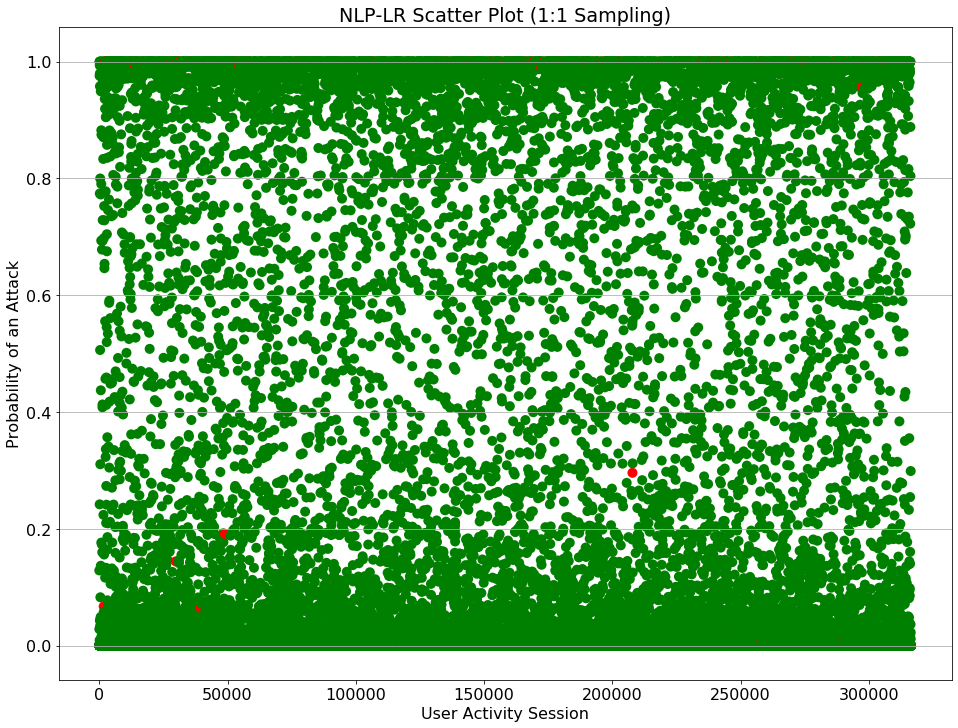

In [12]:
predicted = clf.predict_proba(X_test_vect)[:,1]
x = np.linspace(0, len(predicted), len(predicted))
y = predicted

plt.rc('font', size=16)  
plt.figure(figsize=(16,12))
plt.title('NLP-LR Scatter Plot (1:1 Sampling)')
plt.xlabel('User Activity Session')
plt.ylabel('Probability of an Attack')

colour = np.where(y_test==0,'g',np.where(y_test==1,'r','b'))
plt.scatter(x, y, c=colour, s=100, linewidth=0)
plt.grid(axis='y', linestyle='-')
plt.show()

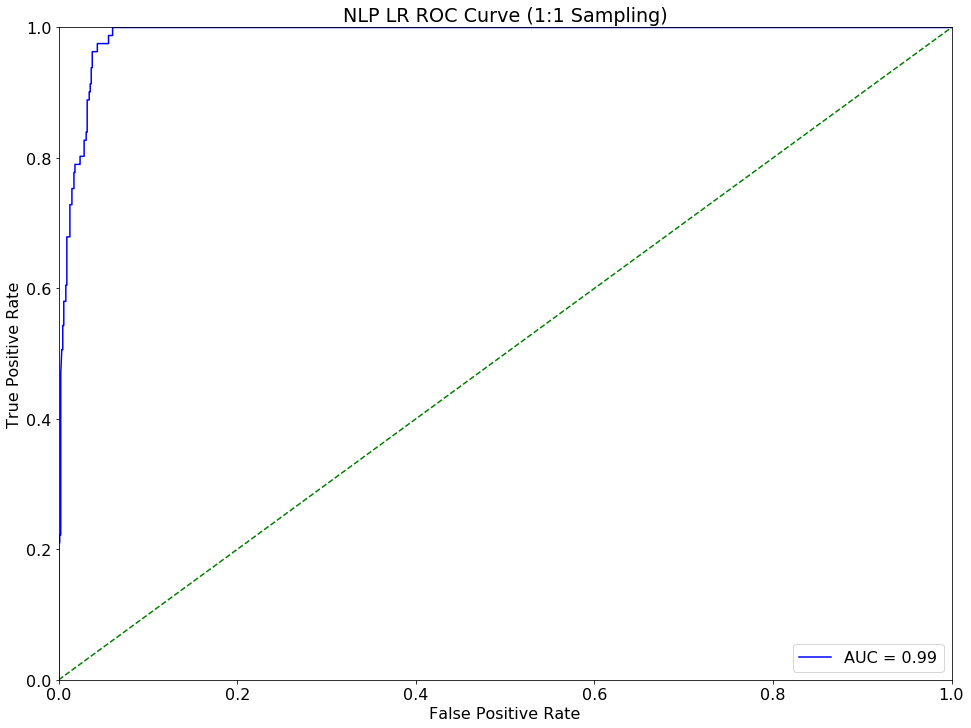

In [84]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, predicted)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(16,12))
plt.title('NLP LR ROC Curve (1:1 Sampling)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


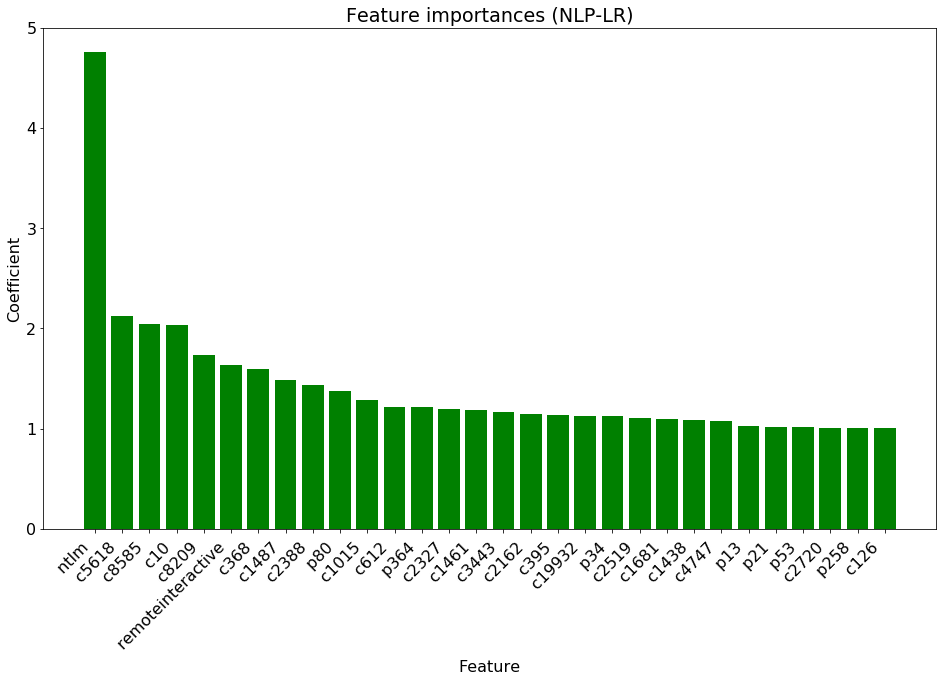

In [100]:
coefs = np.abs(clf.coef_[0])
indices = np.argsort(coefs)[::-1]

orderedFeatures = []
features = ngramVect.get_feature_names()
for index in indices:
    orderedFeatures.append(features[index])

plt.figure(figsize=(16,12))
plt.ylabel('Coefficient')
plt.xlabel('Feature')
plt.title("Feature importances (NLP-LR)")
plt.bar(range(30), coefs[indices[:30]], color="g", align="center")
plt.xticks(range(30), orderedFeatures, rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)
